# Hybrid Search

## Import the needed packages

In [22]:
from pinecone import Pinecone, ServerlessSpec
from pinecone_text.sparse import BM25Encoder
from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm
import torch
import os
from math import ceil
from datasets import load_dataset
from dotenv import load_dotenv, find_dotenv
from IPython.core.display import HTML
from io import BytesIO
from base64 import b64encode

_ = load_dotenv(find_dotenv(filename="secrets.env", raise_error_if_not_found=True))
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"] 
PINECONE_API_KEY = os.environ["PINECONE_API_KEY"] 
INDEX_NAME = "hybrid-search-tutorial"

## Set up Pinecone

In [31]:
# Select the device to run on
if torch.cuda.is_available():
	device = "cuda"
elif torch.backends.mps.is_available():
	device = "mps"
else:
	device = "cpu"
print(f"device: {device}")

# setup the pinecone client
pineconeClient = Pinecone(api_key=PINECONE_API_KEY)

# create the index (delete first if already existing)
if INDEX_NAME in [index["name"] for index in pineconeClient.list_indexes().indexes]:
	pineconeClient.delete_index(name=INDEX_NAME)
	print(f"index: {INDEX_NAME} has been deleted")

pineconeClient.create_index(
	name=INDEX_NAME,
	dimension=512,
	metric="dotproduct",
	spec=ServerlessSpec(
		cloud="aws",
		region="us-west-2"
	)
)

# setup the pinecone index
index = pineconeClient.Index(name=INDEX_NAME)
print(f"index: {INDEX_NAME} has been set up")

device: mps
index: hybrid-search-tutorial has been deleted
index: hybrid-search-tutorial has been set up


## Load the dataset

In [3]:
fashionDataset = load_dataset(
	path = "ashraq/fashion-product-images-small",
	split="train"
)
fashionDataset

Dataset({
    features: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image'],
    num_rows: 44072
})

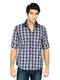

In [4]:
# Separate the images from the text data
images = fashionDataset["image"]
metadata = fashionDataset.remove_columns(column_names="image")
images[0]

In [5]:
# cast the text data to a pandas 
metadata = metadata.to_pandas()
metadata.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


## Create the sparse vectors using BM25

In [6]:
# instance of the encoder
bm25 = BM25Encoder()

# fit the encoder
bm25.fit(metadata["productDisplayName"])

# encode the queries
bm25.encode_queries(metadata["productDisplayName"][1])
bm25.encode_documents(metadata["productDisplayName"][1])

# metadata["productDisplayName"][1]

  0%|          | 0/44072 [00:00<?, ?it/s]

{'indices': [2783072804,
  353257611,
  632192512,
  201915537,
  3905155331,
  120765854],
 'values': [0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887]}

## Create the dense vectors using CLIP

In [7]:
# instance the model
CLIPencoder = SentenceTransformer(
	model_name_or_path="sentence-transformers/clip-ViT-B-32",
	device=device
)

# test it 
CLIPencoder.encode(metadata["productDisplayName"][1]).shape

(512,)

## Create the sparse and dense embeddings

In [32]:
# hyperparameters
BATCH_SIZE = 200
MAX_ARTICLE = 1000
df = metadata.iloc[:MAX_ARTICLE, :]

# Loop through the dataset to create the embeddings
for i in tqdm(range(0, ceil(MAX_ARTICLE/BATCH_SIZE))):

	# Define the index of the elements of this batch
	i_start, i_end = i*BATCH_SIZE, min(MAX_ARTICLE,(i+1)*BATCH_SIZE)

	# Join together all data points for each article (except "id" and "year") to create the metadata of this batch
	batchItemDescription = [" ".join([el for el in row]) for index, row in 
				  df.drop(["id", "year"], axis=1).iloc[i_start:i_end,:].iterrows()]

	# Extract the images of this batch
	batchImages = images[i_start:i_end]

	# Create the sparse embeddings with the BM25 encoder
	batchSparseEmb = bm25.encode_documents(batchItemDescription)

	# Create the dense embeddings with CLIP encoder
	batchDenseEmb = CLIPencoder.encode(batchImages).tolist()

	# Generate the ids
	ids = [str(index) for index in range(i_start, i_end)]
	
	# Structure the metadata as a dict
	batchMetadata = df.iloc[i_start:i_end, :].to_dict(orient="records")

	# prepare the package for upsert
	package = [{
		"id": id_,
		"sparse_values": sparse,
		"values": dense,
		"metadata": data,
	} for id_, sparse, dense, data in zip(ids, batchSparseEmb, batchDenseEmb, batchMetadata)]

	# upload the package in Pinecone
	index.upsert(package)

# Describe the index after populating it
index.describe_index_stats()

  0%|          | 0/5 [00:00<?, ?it/s]

{'dimension': 512,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 1000}},
 'total_vector_count': 1000}

## Create hybrid search

### Helper function to visualise the results


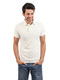
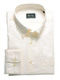
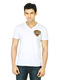
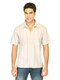
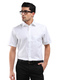
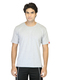
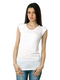
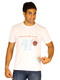
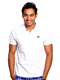
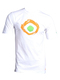
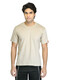
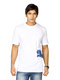
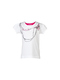
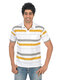

In [46]:
# function to display product images
def displayResults(image_batch):
    figures = []
    for img in image_batch:
        b = BytesIO()
        img.save(b, format='png')
        figures.append(f'''
            <figure style="margin: 5px !important;">
              <img src="data:image/png;base64,{b64encode(b.getvalue()).decode('utf-8')}" style="width: 90px; height: 120px" >
            </figure>
        ''')
    return HTML(data=f'''
        <div style="display: flex; flex-flow: row wrap; text-align: center;">
        {''.join(figures)}
        </div>
    ''')

### Hybrid search with alpha to scale the query

In [65]:
def hybridSearch(query, top_k = 10, alpha = 0.5):
	
	if alpha < 0 or alpha > 1:
		raise ValueError("alpha need to be between 0 and 1")

	# create the sparse embedding
	sparse = bm25.encode_queries(query)

	# create the dense embedding
	dense = CLIPencoder.encode(query).tolist()

	# scale both vectors according to alpha
	hDense = [alpha*v for v in dense]
	hSparse = {
		"indices": sparse["indices"],
		"values": [(1-alpha)*v for v in sparse["values"]]
	}

	results = index.query(
		top_k=top_k,
		vector=hDense,
		sparse_vector=hSparse,
		include_metadata=True
	)

	imgs = [images[int(res["id"])] for res in results.matches]

	return imgs, results.matches

### Query

In [75]:
query = "white sport shoes"

### Alpha = 0.5 (normal search)

In [76]:
imgs, results = hybridSearch(query=query)
print([match["metadata"]["productDisplayName"] for match in results])

['Fila Men Glow White Sports Shoes', 'ADIDAS Men Sukoi White Sports Shoes', 'Deni Yo Men White Jeans', 'ADIDAS Men White Aztek Shoes', 'Puma Men Future Cat Remix SF White Sports Shoes', 'Nike Men Air Rift MTR White Casual Shoe', 'Numero Uno Men White Shoes', 'Nike Men Air Relentless 2 MSL White Sports Shoes', 'Puma Women Speeder Wns Ind White Sports Shoes', 'Nike Men White T-Lite 9 SL Shoes']



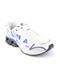
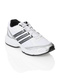
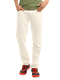
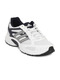
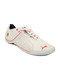
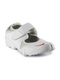
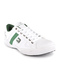
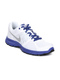
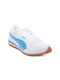
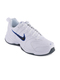

In [77]:
displayResults(imgs)

### Alpha = 1 (full dense search)

In [78]:
imgs, results = hybridSearch(query=query, alpha=1)
print([match["metadata"]["productDisplayName"] for match in results])

['Fila Men Glow White Sports Shoes', 'Deni Yo Men White Jeans', 'ADIDAS Men Sukoi White Sports Shoes', 'ADIDAS Men White Aztek Shoes', 'Nike Men Air Rift MTR White Casual Shoe', 'Puma Men Future Cat Remix SF White Sports Shoes', 'Numero Uno Men White Shoes', 'Nike Men Air Relentless 2 MSL White Sports Shoes', 'Puma Women Speeder Wns Ind White Sports Shoes', 'Puma Men Pack of 3 Socks']



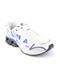
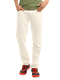
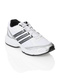
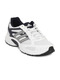
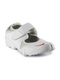
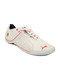
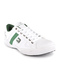
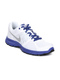
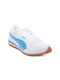
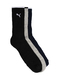

In [79]:
displayResults(imgs)

### Alpha = 0 (full sparse search)

In [80]:
imgs, results = hybridSearch(query=query, alpha=0)
print([match["metadata"]["productDisplayName"] for match in results])

['ADIDAS Men Sports White Sports Shoes', 'ADIDAS Men White Corona Sports Shoes', 'Nike Women Downshifter White Sports Shoes', 'ADIDAS Men Sukoi White Sports Shoes', 'Fila Men Glow White Sports Shoes', 'Puma Men Axis White & Grey Sports Shoes', 'ADIDAS Men White Duramo 3 Sports Shoes', 'Lotto Men Basketball Mid White Sports Shoe', 'F Sports Men White Outlander Sports Shoes', 'Nike Men Zoom Structure White Sports Shoes']



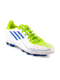
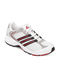
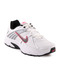
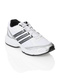
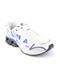
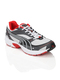
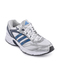
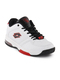
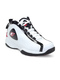
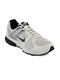

In [81]:
displayResults(imgs)